# Introduction
This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.



<font color = 'blue'>
Content:
    
1. [Libraries](#1)
1. [Load and Check Data](#2)
1. [Feature Engineering](#3)
    * [3.1. Random Noise](#4)
    * [3.2. Lag/Shifted Features ](#5)
    * [3.3. Rolling Mean Features ](#6)    
    * [3.4. Exponentially Weighted Mean Features ](#7)
1. [LightGBM Model](#8)
    * [4.1. One-Hot Encoding](#9)
    * [4.2. Converting sales to log(1+sales)](#10)
    * [4.3. Custom Cost Function](#11) 
    * [4.4. Time-Based Validation Sets](#12)
    * [4.5. LightGBM Parameters](#13)
    * [4.6. Feature Importance](#14)
    * [4.7. Final Model](#15)
1. [Kaggle Submission](#16)
1. [References](#17)
    
   

<a id = "1"></a><br>
# 1. Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools


import warnings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

<a id = "2"></a><br>
# 2. Load and Check Data

In [2]:
train = pd.read_csv('../input/demandforecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demandforecasting/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)



In [4]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [5]:
df["date"].min()

Timestamp('2013-01-01 00:00:00')

In [6]:
df["date"].max()

Timestamp('2018-03-31 00:00:00')

In [7]:
# Satış dağılımı nasıl?
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [8]:
# Kaç store var?
df[["store"]].nunique()

store    10
dtype: int64

In [9]:
# Kaç item var?
df[["item"]].nunique()

item    50
dtype: int64

In [10]:
# Her store'da eşit sayıda mı eşsiz item var?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [11]:
# Peki her store'da eşit sayıda mı sales var?
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [12]:
# mağaza-item kırılımında satış istatistikleri
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

<a id = "3"></a><br>
# 3. Feature Engineering

In [13]:
########################
# Date Features
########################


def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [14]:
df = create_date_features(df)


In [15]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [16]:
# store-item-month kırılımında satış istatistikleri
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

<a id = "4"></a><br>
## 3.1 Random Noise

In [17]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

<a id = "5"></a><br>
## 3.2 Lag/Shifted Features

In [18]:
# buradaki feature sıralaması önemli, önce store, item, date olark belirledim
# lagler geçmiş değerleri ifade ediyor
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [19]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [20]:
# bir ay bir gün öncesi 91, bir ay bir hafta öncesi 98, iki hafta öncesi 105
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

<a id = "6"></a><br>
## 3.3 Rolling Mean Features

In [21]:
# Rolling Mean Features
########################
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [365, 546])
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,41.110797,54.387724,66.502342,66.608239,66.354684,81.640765,78.272879,60.874917,97.691982,71.406884,86.861912,85.392502
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,65.024441,49.523072,67.253311,59.507639,75.703376,80.749703,80.242596,70.905115,79.510405,70.656686,84.022908,81.810701
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,60.276608,62.447953,70.527524,64.841051,70.518583,87.671597,80.898499,68.469618,98.664568,76.375235,86.939389,84.639609
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,78.598253,74.139802,72.595980,68.148100,65.476711,82.407196,90.457179,71.944665,78.068675,81.107908,87.281858,84.988425
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,62.348728,69.175040,50.533918,70.459498,51.296269,78.085474,103.636020,101.066112,98.391311,80.871106,88.862187,84.898829


<a id = "7"></a><br>
## 3.4 Exponentially Weighted Mean Features

In [22]:
# Exponentially Weighted Mean Features
########################
# burada kaç gün öncesine gideyim, 95 gün mü, 98 gün mü gibi ve
# ağırlaklandırmayı nasıl yapmalıyım gibi
# fonksiyonumuzu tanımlayalım ilk başta;

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,41.110797,54.387724,66.502342,66.608239,66.354684,81.640765,78.272879,60.874917,97.691982,71.406884,86.861912,85.392502,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,65.024441,49.523072,67.253311,59.507639,75.703376,80.749703,80.242596,70.905115,79.510405,70.656686,84.022908,81.810701,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,60.276608,62.447953,70.527524,64.841051,70.518583,87.671597,80.898499,68.469618,98.664568,76.375235,86.939389,84.639609,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,78.598253,74.139802,72.595980,68.148100,65.476711,82.407196,90.457179,71.944665,78.068675,81.107908,87.281858,84.988425,73.257320,74.370379,71.987423,66.935919,99.166487,100.046678,68.218343,79.954327,82.582997,72.519244,73.683198,71.948850,66.846786,99.261778,101.083682,68.377473,80.822562,82.133115,71.007644,72.151037,71.783969,66.606893,99.211911,103.109627,68.550876,82.314892,81.134709,69.403475,70.452564,71.480559,66.298892,98.791375,105.022491,68.602440,83.485707,80.000156,66.038719,66.956088,70.379233,65.5418

<a id = "8"></a><br>
# 4. LightGBM Model
<a id = "9"></a><br>
## 4.1. One-Hot Encoding

In [23]:

# veri setinde kategorik değişkenler vardı. bunlar için dummy değişkeni oluşturuyorum
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


<a id = "10"></a><br>
## 4.2. Converting Sales to Log (1+sales)

In [24]:
# Converting sales to log(1+sales)
########################
df['sales'] = np.log1p(df["sales"].values)

<a id = "11"></a><br>
## 4.3. Custom Cost Function

In [25]:
# Custom Cost Function
########################
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

<a id = "12"></a><br>
## 4.4. Time-Based Validation Sets

In [26]:
# Time-Based Validation Sets
########################
test

# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# validasyon 2017 nin ilk üç ayı
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# bağımsız değişkenleri çıkarttım
# şu an test setiyle ilgilenmiyorum
# şu an sadece trainle ilgileniyorum
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [27]:
# train seti için bağımlı değişkenin seçilmesi
Y_train = train['sales']

# train seti için bağımsız değişkenin seçilmesi
X_train = train[cols]

# validasyon seti için bağımlı değişkenin seçilmesi
Y_val = val['sales']

# validasyon seti için bağımsız değişkenin seçilmesi
X_val = val[cols] 

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

# train seti içerisinde 730500 gözlem var
# test seti (y_val) içerisinde 45000 gözlem var.
# y_valisdayosnu 2018 deki test setimize banzettik

((730500,), (730500, 142), (45000,), (45000, 142))

<a id = "13"></a><br>
## 4.5. LightGBM Parameters

In [28]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000, # light gbm en önemli parametris boost sayısı, iterasyon sayısı
              'early_stopping_rounds': 200,
              'nthread': -1}


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain, # parametreler
                  valid_sets=[lgbtrain, lgbval], # datalarımız
                  num_boost_round=lgb_params['num_boost_round'], # yukarıdaki fonksiyonda çektik
                  early_stopping_rounds=lgb_params['early_stopping_rounds'], # yukarıdaki fonksiyonda çektik
                  feval=lgbm_smape,
                  verbose_eval=100) # her 100 iterasyonda rapor ver


# en iyi iterasyon sayısını model.best_iterationla giriyoruz
# sadece model.best_iterationu çalıştırdığımızda bize en iyi değeri gösteriyor
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.319430 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.172676	training's SMAPE: 17.6092	valid_1's l1: 0.171217	valid_1's SMAPE: 17.5003
[200]	training's l1: 0.142399	training's SMAPE: 14.5839	valid_1's l1: 0.145335	valid_1's SMAPE: 14.9086
[300]	training's l1: 0.136725	training's SMAPE: 14.0158	valid_1's l1: 0.140792	valid_1's SMAPE: 14.4531
[400]	training's l1: 0.134649	training's SMAPE: 13.8092	valid_1's l1: 0.139189	valid_1's SMAPE: 14.2929
[500]	training's l1: 0.133279	training's SMAPE: 13.6723	valid_1's l1: 0.137707	valid_1's SMAPE: 14.144
[600]	training's l1: 0.13231	training's SMAPE: 13.5756	valid_1's l1: 0.136647	valid_1's SMAPE: 14.0373
[700]	training's l1: 0.131594	training's SMAPE: 13.5041	valid_1's l1: 0.135949	valid_1's SMAPE: 13.9671
[800]	training's l1: 0.131007	training's SMAPE:

In [29]:
# en iyi iterasyon sayısını model.best_iterationla giriyoruz
# sadece model.best_iterationu çalıştırdığımızda bize en iyi değeri gösteriyor
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [30]:
# burada dönüştürme işlemi yaptık.
# daha önce standartlaştırma işlemi yapımıştık. bunu gezi almamız gerekiyor
# yukarıda yapmış olduğumuz logaritmik dönüşümü geri almak için
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.82264637797821

<a id = "14"></a><br>
## 4.6. Feature Importance

                         feature  split       gain
17           sales_roll_mean_546    917  54.265755
13                 sales_lag_364   1290  13.475416
16           sales_roll_mean_365    588   9.867399
60    sales_ewm_alpha_05_lag_365    384   4.879878
18    sales_ewm_alpha_095_lag_91     87   2.692846
1                    day_of_year    759   2.081161
54     sales_ewm_alpha_05_lag_91     93   1.880548
3                        is_wknd    221   1.214132
123                day_of_week_0    236   1.182269
141                     month_12    310   1.126394
36     sales_ewm_alpha_08_lag_91     13   0.900549
2                   week_of_year    287   0.884241
6                   sales_lag_91     78   0.819293
27     sales_ewm_alpha_09_lag_91     32   0.578289
62    sales_ewm_alpha_05_lag_728    404   0.398517
7                   sales_lag_98     18   0.392669
59    sales_ewm_alpha_05_lag_270    184   0.373672
44    sales_ewm_alpha_08_lag_728     24   0.310238
53    sales_ewm_alpha_07_lag_72

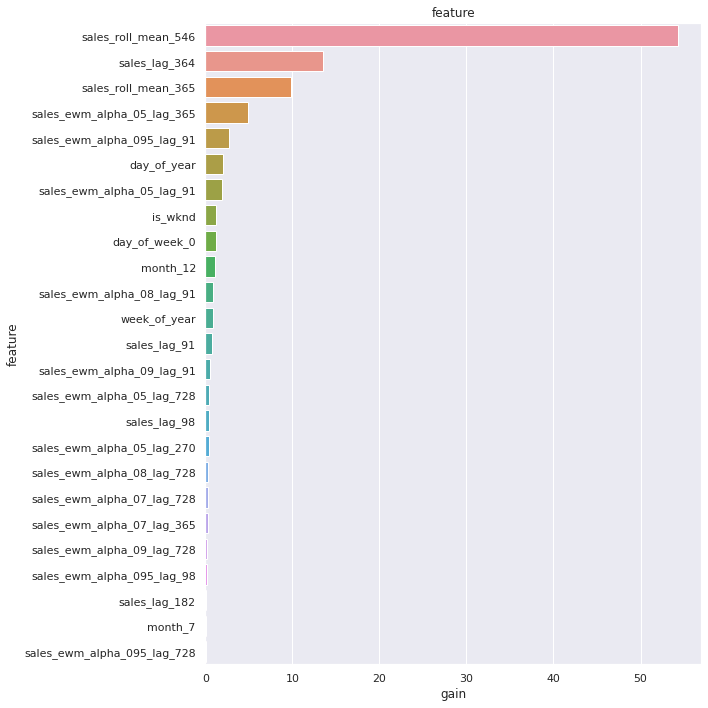

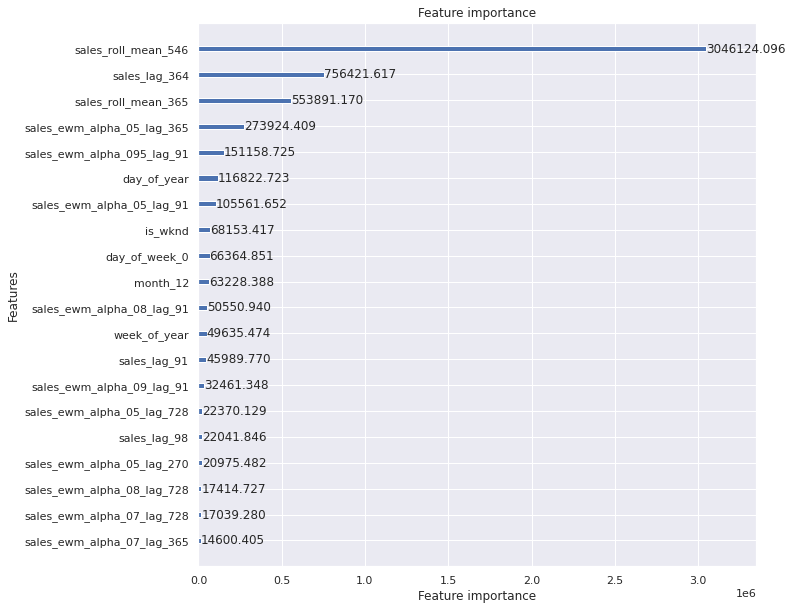

In [31]:
########################
# Değişken önem düzeyleri
########################
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))



plot_lgb_importances(model, num=30)
plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

<a id = "15"></a><br>
## 4.7. Final Model

In [32]:
# Final Model
########################
train = df.loc[~df.sales.isna()] # sales değişkeninde eskik değer sahip olmayanları getiriyoruz
Y_train = train['sales'] # y bağımsız değişkeni
X_train = train[cols]

test = df.loc[df.sales.isna()] # df içerisindeki na olan salesleri seçtik
X_test = test[cols]  #  test setinin bağımszı değişkenlerini seçtik,
# test setinin bağımlı değişkeni yokki zaten boş


lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


# LightGBM dataset
# train setini oluşturuyoruz tekrar
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
# modeli kuracağım
# lgbtrain_all, parametreler, be best iterasyonda modelde
model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

# test setini de tahmin edeceğiz
# test stinin bağımlı değişkenini ahmin edeceğiz, daha sonra bunlar test_preds olarak
# bunu da daha sonra kaggle göndermemiz lazım
test_preds = model.predict(X_test, num_iteration=model.best_iteration)



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.373675 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [33]:
test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,...,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,10.402334,16.184212,24.268973,13.355977,15.377830,16.251150,17.090262,14.656071,15.876475,10.399482,20.982697,23.124082,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,19.958850,15.985002,23.087050,20.158654,26.777043,21.745150,22.958692,11.865336,28.691163,15.048022,24.160690,23.673314,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,NaN,2.0,3,3,1,2018,0,0,0,14.855831,26.417329,18.615930,13.175695,22.964886,22.830456,21.928469,15.571970,22.222545,17.505602,22.954947,19.820168,15.136181,26.541328,20.053482,13.341738,31.929975,23.099505,10.259436,22.419609,15.800009,15.249875,26.071202,20.117707,13.673801,31.819693,23.196054,10.535964,22.786783,15.600177,15.445467,25.137412,20.299243,14.348799,31.477923,23.368290,11.134660,23.413319,15.203919,15.667677,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2018-01-04,NaN,3.0,4,4,1,2018,0,0,0,21.554555,22.438973,19.848118,26.693413,30.495069,26.312463,30.570988,16.020003,34.518298,14.010255,25.187747,18.636435,19.756809,23.177066,20.002674,25.367087,27.246499,20.154975,15.712972,32.470980,12.190000,19.524988,23.307120,20.011771,24.767380,27.481969,20.319605,15.453596,31.978678,12.360018,19.089093,23.427482,20.059849,23.669760,27.895585,20.673658,15.026932,31.082664,12.640784,18.700303,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2018-01-05,NaN,4.0,5,5,1,2018,1,0,0,16.685941,30.290598,26.984872,28.195159,26.865372,39.499764,30.242334,24.674960,31.154623,12.629590,26.466709,23.099277,19.037840,27.758853,27.600134,27.868354,31.762325,19.057749,14.085649,33.923549,12.009500,19.052499,27.530712,27.201177,27.676738,31.548197,19.131961,14.145360,33.797868,12.036002,19.017819,27.08

<a id = "16"></a><br>
# 5. Submission

In [34]:
# KAGGLE SUBMISSION
# test setinin id ve sales değişkenlerini submission_df olarak oluşturuyorum
submission_df = test.loc[:, ['id', 'sales']]
# standartlşatırma işlemi yapımıştık bunları geri alıyoruz,
# submission_df'in içine sale olarak atıyorum
submission_df['sales'] = np.expm1(test_preds)
# idler küsüratlı geldiği için integera çevirdik
submission_df['id'] = submission_df.id.astype(int)
# submission dosyasını kaggle için çıkartıyorum
submission_df.to_csv('submission_demand.csv', index=False)
# buradaki idler kagglen beklediği formatta, yani
# sıfırıncı indeks; mağaza birin, birinci ürününün, birinci aydaki tahminini ifade ediyor
# birinci indeks: mağaza birin, ikinci ürününün, birinci aydaki tahmini ifade ediyor
submission_df.head(10)

,id,sales
0,0,12.695325
1,1,14.741009
2,2,13.321334
3,3,14.333126
4,4,18.646462
5,5,18.174822
6,6,18.995995
7,7,12.552622
8,8,15.796344
9,9,12.955656


In [35]:
# eğer orijisanl test setine tahminlerimizi eklemek istersek
# bunun için orjinal test setini tekrar çağıralım
test_orginal = pd.read_csv('../input/demandforecasting/test.csv', parse_dates=['date'])
test_orginal.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [36]:
# orjinal test seti ile tahmin edilen satış değerlerini birleştiriyoruz
pd.merge(test_orginal, submission_df, how = "inner", on = "id")

,id,date,store,item,sales
0,0,2018-01-01,1,1,12.695325
1,1,2018-01-02,1,1,14.741009
2,2,2018-01-03,1,1,13.321334
3,3,2018-01-04,1,1,14.333126
4,4,2018-01-05,1,1,18.646462
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,70.289090
44996,44996,2018-03-28,10,50,73.337146
44997,44997,2018-03-29,10,50,77.403886
44998,44998,2018-03-30,10,50,82.067487


<a id = "17"></a><br>
# 6. References
* https://github.com/mvahit
* https://www.veribilimiokulu.com/
* https://www.kaggle.com/haticeebraralc